In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

## Data

In [5]:
test_section = pd.read_table("DeepBlue/biaseddata.csv",  index_col=0)
test_section.head()

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,maggie clark pew SOURCE staff writer 21 states...,600,0.0,0.0,Neutral,0,0
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral,washington -- the senate judiciary committee a...,600,0.0,0.0,Neutral,0,0
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,0.0,0.0,Neutral,0,0
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"parts of obamacare are starting to fray, even ...",600,0.0,0.0,Neutral,0,0
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,0.0,0.0,Neutral,0,0


In [6]:
test_section["bias_magnitude"] = np.abs(test_section["democrat.bias"]-test_section["republican.bias"])
test_section.head()

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,bias_magnitude
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral,maggie clark pew SOURCE staff writer 21 states...,600,0.0,0.0,Neutral,0,0,0.0
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral,washington -- the senate judiciary committee a...,600,0.0,0.0,Neutral,0,0,0.0
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,0.0,0.0,Neutral,0,0,0.0
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,"parts of obamacare are starting to fray, even ...",600,0.0,0.0,Neutral,0,0,0.0
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,0.0,0.0,Neutral,0,0,0.0


<AxesSubplot:>

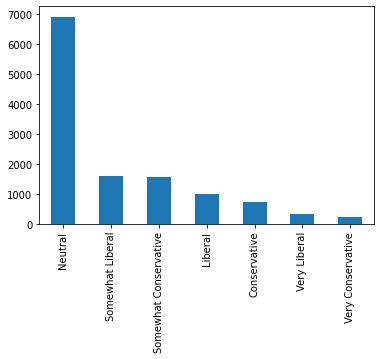

In [7]:
fig, ax = plt.subplots()
test_section["biaslabel"].value_counts().plot(ax=ax, kind="bar")

<AxesSubplot:>

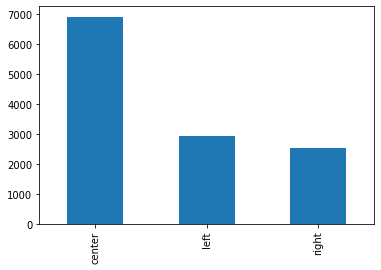

In [8]:
test_section["bias_text"] = test_section["biaslabel"]
test_section["bias_text"] = test_section["bias_text"].str.replace("Neutral", "center")
test_section["bias_text"] = test_section["bias_text"].str.replace("Somewhat Liberal", "left")
test_section["bias_text"] = test_section["bias_text"].str.replace("Somewhat Conservative", "right")
test_section["bias_text"] = test_section["bias_text"].str.replace("Very Liberal", "left")
test_section["bias_text"] = test_section["bias_text"].str.replace("Very Conservative", "right")
test_section["bias_text"] = test_section["bias_text"].str.replace("Liberal", "left")
test_section["bias_text"] = test_section["bias_text"].str.replace("Conservative", "right")

fig, ax = plt.subplots()
test_section["bias_text"].value_counts().plot(ax=ax, kind="bar")

In [9]:
drop_indices = np.random.choice(test_section[test_section["bias_text"]=="center"].index, 4000, replace=False)
drop_indices

array([ 2376,  7219, 11127, ...,  4844,  5488,  4038])

In [10]:
test_section.iloc[drop_indices].head()

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,bias_magnitude,bias_text
2376,http://www.washingtonpost.com/politics/federal...,News,0,Economy,Healthcare,Neutral,Neutral,"in a weird way, this stupid government shutdow...",600,0.0,0.0,Neutral,0,0,0.0,center
7219,http://www.usatoday.com/story/news/nation/2013...,News,1,Gay Rights,None,Neutral,Neutral,"richard wolf, SOURCE doma has been declared...",426,0.0,0.0,Neutral,0,0,0.0,center
11127,http://www.breitbart.com/Big-Government/2013/0...,Opinion,1,None,None,Neutral,Neutral,"the national immigration forum (nif), the forc...",600,0.0,0.0,Neutral,0,0,0.0,center
7337,http://www.latimes.com/news/nationworld/nation...,News,1,Gay Rights,None,Neutral,Neutral,advocates for same-sex marriage set an ambitio...,600,0.0,0.0,Neutral,0,0,0.0,center
6595,http://www.foxnews.com/politics/2013/03/14/ope...,Opinion,1,Elections,None,Neutral,Neutral,the palmetto state basks in the political lime...,600,0.0,0.0,Neutral,0,0,0.0,center


<AxesSubplot:>

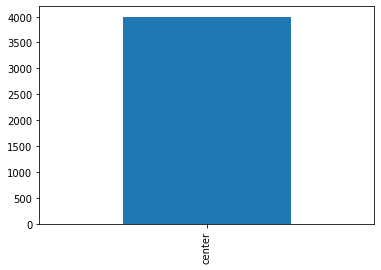

In [11]:
fig, ax = plt.subplots()
test_section["bias_text"].iloc[drop_indices].value_counts().plot(ax=ax, kind="bar")


In [12]:
test_section_balanced = test_section.drop(drop_indices)
test_section_balanced = test_section_balanced.reset_index()
test_section_balanced.head()

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,bias_magnitude,bias_text
0,2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,0.0,0.0,Neutral,0,0,0.0,center
1,4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,0.0,0.0,Neutral,0,0,0.0,center
2,8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,the following irresponsible police...,498,0.5,-0.5,Liberal,1,1,1.0,left
3,9,http://www.nytimes.com/2013/05/24/us/politics/...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,an alternative possibility is that a bipartisa...,372,0.0,0.0,Neutral,0,0,0.0,center
4,11,http://www.latimes.com/news/local/la-me-cap-gu...,other,0,Civil Rights,Civil Rights,Neutral,SomewhatPositive,"sacramento — “living in parallel universes,” i...",600,0.0,0.5,Somewhat Conservative,1,-1,0.5,right


<AxesSubplot:>

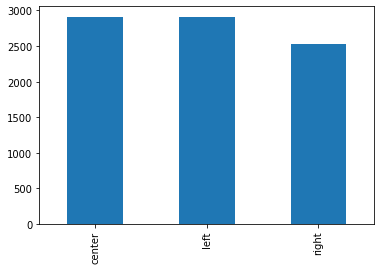

In [13]:

fig, ax = plt.subplots()
test_section_balanced["bias_text"].value_counts().plot(ax=ax, kind="bar")

<AxesSubplot:>

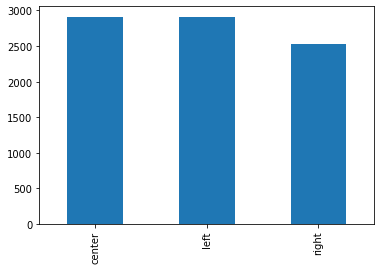

In [14]:
test_section_old = test_section
test_section = test_section_balanced
test_section["content"] = test_section["article"]
test_section["pred_labels"] = 4
fig, ax = plt.subplots()
test_section["bias_text"].value_counts().plot(ax=ax, kind="bar")

In [15]:
test_section

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,bias_magnitude,bias_text,content,pred_labels
0,2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,0.0,0.0,Neutral,0,0,0.0,center,david cole is a professor of constitutional la...,4
1,4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,0.0,0.0,Neutral,0,0,0.0,center,u.s. immigration citizenship and immigration s...,4
2,8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,the following irresponsible police...,498,0.5,-0.5,Liberal,1,1,1.0,left,the following irresponsible police...,4
3,9,http://www.nytimes.com/2013/05/24/us/politics/...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,an alternative possibility is that a bipartisa...,372,0.0,0.0,Neutral,0,0,0.0,center,an alternative possibility is that a bipartisa...,4
4,11,http://www.latimes.com/news/local/la-me-cap-gu...,other,0,Civil Rights,Civil Rights,Neutral,SomewhatPositive,"sacramento — “living in parallel universes,” i...",600,0.0,0.5,Somewhat Conservative,1,-1,0.5,right,"sacramento — “living in parallel universes,” i...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,12345,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,president obama won reelection in part by beat...,600,0.5,-0.5,Liberal,1,1,1.0,left,president obama won reelection in part by beat...,4
8346,12346,http://news.yahoo.com/republicans-hatred-obama...,Opinion,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,"red-faced republicans, circling and preparing ...",600,0.5,-0.5,Liberal,1,1,1.0,left,"red-faced republicans, circling and preparing ...",4
8347,12347,http://www.washingtonpost.com/opinions/dana-mi...,News,1,Republican Scandals,Republican Scandals,Neutral,Neutral,rep. steve stockman’s moment as a viable senat...,600,0.0,0.0,Neutral,0,0,0.0,center,rep. steve stockman’s moment as a viable senat...,4
8348,12348,http://www.washingtonpost.com/opinions/ej-dion...,News,1,Republican Scandals,Republican Scandals,SomewhatPositive,SomewhatNegative,we interrupt this highly partisan and ideologi...,600,0.5,-0.5,Liberal,1,1,1.0,left,we interrupt this highly partisan and ideologi...,4


In [16]:

test_section.to_csv("test_dataset.csv", sep='\t')

In [17]:
# model.save_pretrained(save_path)

In [18]:
tf.keras.backend.clear_session()